In [104]:
# Packages
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.nn as jnn
import jax.numpy as jnp
from jax import random

import flax.linen as nn
from flax.training import train_state

import optax

In [38]:
data = np.array([0,1,2,3,4,5,6,7,8,9])      #       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
data[5]     # 5th position                          [5]
data[3:6]   # From 3rd to 5th position              [3, 4, 5]
data[:5]    # First 5                               [0, 1, 2, 3, 4]
data[5:]    # Without the first 5 (From 6th one)    [5, 6, 7, 8, 9]
data[-4]    # Fourth from behind                    [6]
data[::2]   # Every Second                          [0, 2, 4, 6, 8]
data[::-2]  # Every Second from behind              [9, 7, 5, 3, 1]
data[::-1]  # Reverse Order                         [9, 8, 7, 6, 5, 4, 3, 2, 1, 0]
np.dot([1,2,3], data[0:3][::-1])    #               Dot Product v^T * v

4

### AR(p) simulator

$X_t = c + \beta_1X_{t-1} + \beta_2X_{t-2} + ... + \beta_pX_{t-p} + \epsilon  \quad ,\epsilon \sim \mathcal{N}(0, \sigma^2)$

In [3]:
def sample_ar_process(n_samples, ar_params, noise_std = 1.0, initial_values = None):
    p = len(ar_params)

    if initial_values is None:
        initial_values = np.zeros(p)
    
    # Initial data with zero's
    data = np.zeros(n_samples)
    # First p values
    data[:p] = initial_values

    # Generate AR(p) process:
    for i in range(p, n_samples):
        noise = np.random.normal(0, noise_std)
        data[i] = np.dot(ar_params, data[i-p:i][::-1]) + noise
    return data
    

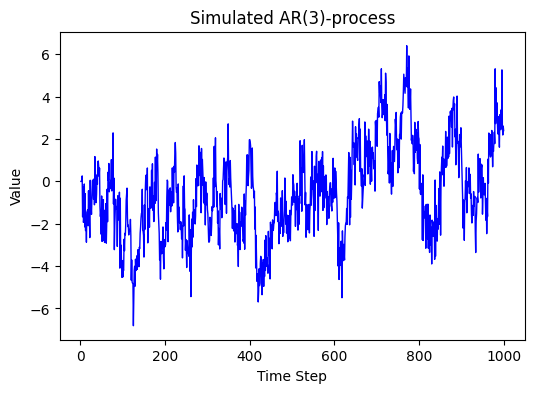

In [4]:
ar_data = sample_ar_process(n_samples = 1000, ar_params = np.array([0.33, 0.5, 0.1]))
ar_data = np.array([np.arange(1,len(ar_data)+1),ar_data])
plt.figure(figsize=(6,4))
plt.plot(ar_data[0], ar_data[1], linewidth = 1, color ='blue')
plt.title("Simulated AR(3)-process")
plt.ylabel("Value")
plt.xlabel("Time Step")
plt.show()

### SDE Simulator

$dX_t = a(X_t, t)dt + b(X_t, t)dW_t \\$

$a(X_t, t)$: Drift parameter $\\$
$b(X_t, t)$: Diffusion parameter $\\$
$W_t$: Wiener Process (Brownian motion)

To simulate data we use the **Euler-Maruyama Method**.

$X_t = X_{t-1} + a(X_{t-1}, t-1)\Delta t + b(X_{t-1}, t-1)\Delta W_{t-1} \quad \Delta W \sim \mathcal{N}(0, \Delta t)$

In [2]:
# Drift function
def a(X, t):
    return 0.2 * X
# Diffusion function
def b(X, t):
    return 0.3

def euler_maruyama(n_samples, delta_t, a, b, X0):
    X = np.zeros(n_samples)
    X[0] = X0
    for t in range(1, n_samples):
        # Wiener process
        W = np.random.normal(0, np.sqrt(delta_t))
        X[t] = X[t-1] + a(X[t-1], t*delta_t)*delta_t + b(X[t-1], t*delta_t)*W

    return X



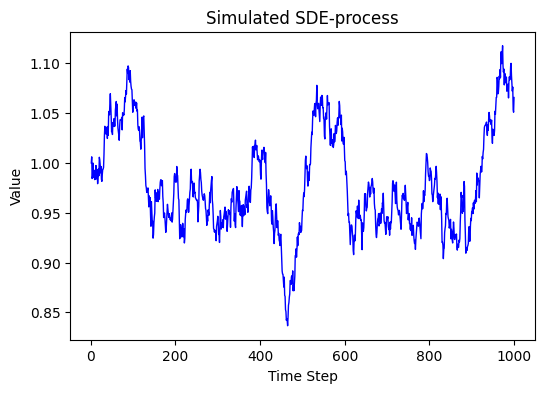

In [3]:
sde_data = euler_maruyama(n_samples = 1000, delta_t = 0.001, a = a, b = b, X0 = 1)
sde_data = np.array([np.arange(1,len(sde_data)+1),sde_data])
plt.figure(figsize=(6,4))
plt.plot(sde_data[0], sde_data[1], linewidth = 1, color ='blue')
plt.title("Simulated SDE-process")
plt.ylabel("Value")
plt.xlabel("Time Step")
plt.show()

### Geometric Brownian Motion

$dS_t = \mu S_tdt + \sigma S_tdW_t \\$

$S_0$: Initial Stock price $\\$
$\mu$: Drift coefficient $\\$
$\sigma$: Volatility coefficient $\\$
$W_t$: Wiener Process (Brownian motion)

In [56]:
import jax.numpy as jnp
from jax import random

def gbm_simulator(key, S0, mu, sigma, T, dt):

    # Number of time steps
    N = int(T / dt)
    t = jnp.linspace(0, T, N)
    W = random.normal(key, (N,)) * jnp.sqrt(dt)
    
    # Wiener process
    W = jnp.cumsum(W)
    S = S0 * jnp.exp((mu - 0.5 * sigma**2) * t + sigma * W)
    return S

# Parameters for the GBM
S0 = 100.0                  # Initial stock price
mu = 0.1                    # Drift coefficient
sigma = 0.2                 # Volatility coefficient
T = 5.0                     # Total time (year)
dt = 0.005                  # Time step

# Generate random key
key = random.PRNGKey(0)

# Simulate GBM
GBM_data = gbm_simulator(key, S0, mu, sigma, T, dt)

Validation data:

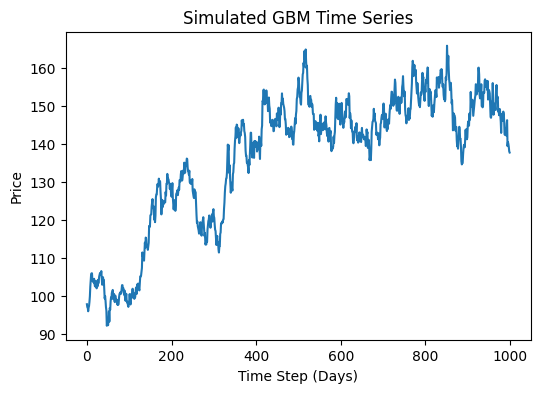

Mean Price: 136.36
Standard Deviation of Price: 17.87


In [57]:
def validate_simulated_data(simulated_data):

    # Plot the time series
    plt.figure(figsize=(6, 4))
    plt.plot(GBM_data)
    plt.title('Simulated GBM Time Series')
    plt.xlabel('Time Step (Days)')
    plt.ylabel('Price')
    plt.show()

    # Calculate and print basic statistics
    mean_price = jnp.mean(simulated_data)
    std_dev_price = jnp.std(simulated_data)
    print(f"Mean Price: {mean_price:.2f}")
    print(f"Standard Deviation of Price: {std_dev_price:.2f}")

# Validate the simulated data
validate_simulated_data(GBM_data)


#### Preprocess the data

In [60]:
# Length of the sequences to be used for prediction
sequence_length = 30  

# Generate sequences and targets
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        targets.append(data[i + seq_length])
    return np.array(sequences), np.array(targets)

states, actions = create_sequences(GBM_data, sequence_length)

# Convert to JAX arrays
states = jnp.array(states)
actions = jnp.array(actions).reshape(-1, 1)

# Normalize the data
mean = jnp.mean(states)
std = jnp.std(states)
states = (states - mean) / std
actions = (actions - mean) / std

# Split into training and validation sets
train_size = int(len(states) * 0.8)
train_states = states[:train_size]
train_actions = actions[:train_size]
val_states = states[train_size:]
val_actions = actions[train_size:]

print("Train sequences shape:", train_states.shape)
print("Train actions shape:", train_actions.shape)
print("Validation sequences shape:", val_states.shape)
print("Validation actions shape:", val_actions.shape)


Train sequences shape: (776, 30)
Train actions shape: (776, 1)
Validation sequences shape: (194, 30)
Validation actions shape: (194, 1)


### LSTM Framework for pre-training the policy network

### Preprocess Data (Creating State-Action pairs)

- **State:** Window of consequtive values from time series.
- **Action:** Next value in the time series.

- **Window size:** 10

In [4]:
def state_action_pairs(data, window):
    states = []
    actions = []

    for i in range(len(data)-window):
        state = data[i:i+window]
        action = data[i+window]
        states.append(state)
        actions.append(action)
    
    return np.array(states), np.array(actions)

states, actions = state_action_pairs(sde_data[1], window=10)

# for i in range(3):
#     print(f"State {i}: {states[i]}")
#     print(f"Action {i}: {actions[i]}")
#     print("")

### S5 JAX framework to train the policy network

State Action Dataset

In [32]:
class StateActionDataset:
    def __init__(self, states, actions):
        self.states = states
        self.actions = actions

    def __len__(self):
        return len(self.states)

    def __getitem__(self, idx):
        return self.states[idx], self.actions[idx]


# Split data into training and validation sets
train_states, val_states, train_actions, val_actions = train_test_split(states, actions, test_size=0.2, random_state=42)

train_dataset = StateActionDataset(train_states, train_actions)
val_dataset = StateActionDataset(val_states, val_actions)

train_s = jnp.array(train_states)
train_a = jnp.array(train_actions)
val_s = jnp.array(val_states)
val_a = jnp.array(val_actions)

S5 Framework

In [33]:
# Define the S5 layer
class S5Layer(nn.Module):
    input_dim: int
    output_dim: int

    def setup(self):
        self.W = self.param('W', nn.initializers.xavier_uniform(), (self.input_dim, self.output_dim))
        self.b = self.param('b', nn.initializers.zeros, (self.output_dim,))

    # Forward pass of the layer
    def __call__(self, x):
        return jnp.dot(x, self.W) + self.b

# Define the S5 block
class S5Block(nn.Module):
    input_dim: int
    output_dim: int

    def setup(self):
        self.s5_layer = S5Layer(self.input_dim, self.output_dim)
        self.norm = nn.LayerNorm()
        self.dropout = nn.Dropout(0.1)

    def __call__(self, x, train: bool = True):
        x = self.s5_layer(x)
        x = jnn.relu(x)
        x = self.norm(x)
        x = self.dropout(x, deterministic=not train)
        return x

# Define the full S5 model
class S5Model(nn.Module):
    input_dim: int
    hidden_dim: int
    num_layers: int
    output_dim: int

    def setup(self):
        self.layers = [
            S5Block(self.input_dim if i == 0 else self.hidden_dim, 
                    self.output_dim if i == self.num_layers - 1 else self.hidden_dim) 
            for i in range(self.num_layers)
        ]

    def __call__(self, x, train: bool = True):
        for i, layer in enumerate(self.layers):
            #print(f"Shape before layer {i}: {x.shape}")
            x = layer(x, train)
            #print(f"Shape after layer {i}: {x.shape}")
        return x


In [34]:
# Initialize the model
input_dim = 10  # Number of features in state
hidden_dim = 10  # Ensure consistent hidden dimensions
output_dim = 1  # Number of features in action
num_layers = 3
model = S5Model(input_dim=input_dim, hidden_dim=hidden_dim, num_layers=num_layers, output_dim=output_dim)

# Create a random input tensor for initialization
x = jnp.ones((1, input_dim))  # [batch_size, feature_dimension]

# Initialize parameters
rng = jax.random.PRNGKey(0)
# Extract 'params' correctly from 'variables'
variables = model.init(rng, x, train=True)
params = variables['params']

Training the policy network

In [35]:
# Define the loss function
def mse_loss(params, apply_fn, x, y, train: bool, rng=None):

    if train and rng is None:
        raise ValueError("RNG key must be provided for training with dropout")
    # Forward pass
    preds = apply_fn({'params': params}, x, rngs={'dropout': rng} if rng else {}, train=train)
    return jnp.mean((preds - y) ** 2)

@jax.jit
def train_step(state, x, y):
    def loss_fn(params):
        rng, rng_dropout = jax.random.split(state.rng)
        preds = state.apply_fn({'params': params}, x, rngs={'dropout': rng_dropout}, train=True)
        loss = jnp.mean((preds - y) ** 2)
        return loss, rng
    
    (loss, rng), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
    state = state.apply_gradients(grads=grads).replace(rng=rng)
    return state, loss

def data_generator(states, actions, batch_size, sequence_length):
    num_samples = len(states) - sequence_length + 1
    for start_idx in range(0, num_samples, batch_size):
        end_idx = min(start_idx + batch_size, num_samples)
        batch_states = [states[i:i + sequence_length] for i in range(start_idx, end_idx)]
        batch_actions = [actions[i + sequence_length - 1] for i in range(start_idx, end_idx)]
        yield jnp.array(batch_states), jnp.array(batch_actions)

In [36]:

num_epochs = 500
batch_size = 32
sequence_length = 10

# Initialize the training state
class TrainState(train_state.TrainState):
    rng: jax.random.PRNGKey
rng = jax.random.PRNGKey(0)
tx = optax.adam(learning_rate=0.001)
state = TrainState.create(apply_fn=model.apply, params=params, tx=tx, rng=rng)

# Training step
for epoch in range(num_epochs):
    # Training
    for batch_states, batch_actions in data_generator(train_states, train_actions, batch_size, sequence_length):
        batch = (jnp.array(batch_states), jnp.array(batch_actions))
        state, loss = train_step(state, batch[0], batch[1])

    # Compute loss on validation set with train=False to disable dropout
    val_loss = mse_loss(state.params, state.apply_fn, jnp.array(val_states), jnp.array(val_actions), train=False)
    print(f'Epoch {epoch + 1}, Validation Loss: {val_loss:.4f}')
    
    # Optionally, print training loss for better insight
    print(f'Epoch {epoch + 1}, Training Loss: {loss:.4f}')

pretrained_params = state.params


Epoch 1, Validation Loss: 0.9085
Epoch 1, Training Loss: 0.8911
Epoch 2, Validation Loss: 0.8622
Epoch 2, Training Loss: 0.8457
Epoch 3, Validation Loss: 0.8176
Epoch 3, Training Loss: 0.7996
Epoch 4, Validation Loss: 0.7749
Epoch 4, Training Loss: 0.7595
Epoch 5, Validation Loss: 0.7341
Epoch 5, Training Loss: 0.7193
Epoch 6, Validation Loss: 0.6948
Epoch 6, Training Loss: 0.6846
Epoch 7, Validation Loss: 0.6574
Epoch 7, Training Loss: 0.6530
Epoch 8, Validation Loss: 0.6217
Epoch 8, Training Loss: 0.6121
Epoch 9, Validation Loss: 0.5875
Epoch 9, Training Loss: 0.5765
Epoch 10, Validation Loss: 0.5547
Epoch 10, Training Loss: 0.5421
Epoch 11, Validation Loss: 0.5234
Epoch 11, Training Loss: 0.5429
Epoch 12, Validation Loss: 0.4937
Epoch 12, Training Loss: 0.4867
Epoch 13, Validation Loss: 0.4653
Epoch 13, Training Loss: 0.4597
Epoch 14, Validation Loss: 0.4382
Epoch 14, Training Loss: 0.4304
Epoch 15, Validation Loss: 0.4124
Epoch 15, Training Loss: 0.4371
Epoch 16, Validation Loss: 0

In [37]:
class Discriminator(nn.Module):
    input_dim: int
    hidden_dim: int
    output_dim: int = 1

    def setup(self):
        self.dense1 = nn.Dense(self.hidden_dim)
        self.dense2 = nn.Dense(self.hidden_dim)
        self.dense3 = nn.Dense(self.output_dim)

    def __call__(self, x):
        x = nn.relu(self.dense1(x))
        x = nn.relu(self.dense2(x))
        x = nn.sigmoid(self.dense3(x))
        return x

# Initialize the discriminator
discriminator = Discriminator(input_dim=input_dim, hidden_dim=hidden_dim)


In [38]:
def discriminator_loss(discriminator_params, policy_params, real_data, fake_data, apply_fn):
    real_preds = apply_fn({'params': discriminator_params}, real_data)
    fake_preds = apply_fn({'params': discriminator_params}, fake_data)
    real_loss = optax.sigmoid_binary_cross_entropy(real_preds, jnp.ones_like(real_preds))
    fake_loss = optax.sigmoid_binary_cross_entropy(fake_preds, jnp.zeros_like(fake_preds))
    return jnp.mean(real_loss + fake_loss)

def policy_loss(policy_params, discriminator_params, state_data, apply_fn_policy, apply_fn_discriminator, rng):
    actions = apply_fn_policy({'params': policy_params}, state_data, rngs={'dropout': rng}, train=True)
    preds = apply_fn_discriminator({'params': discriminator_params}, actions)
    return jnp.mean(optax.sigmoid_binary_cross_entropy(preds, jnp.ones_like(preds)))


In [39]:
@jax.jit
def update_discriminator(state_discriminator, state_policy, real_data, fake_data):
    def loss_fn(discriminator_params):
        return discriminator_loss(discriminator_params, state_policy.params, real_data, fake_data, state_discriminator.apply_fn)
    
    grads = jax.grad(loss_fn)(state_discriminator.params)
    state_discriminator = state_discriminator.apply_gradients(grads=grads)
    return state_discriminator

@jax.jit
def update_policy(state_policy, state_discriminator, state_data, rng):
    def loss_fn(policy_params):
        return policy_loss(policy_params, state_discriminator.params, state_data, state_policy.apply_fn, state_discriminator.apply_fn, rng)
    
    loss, grads = jax.value_and_grad(loss_fn)(state_policy.params)
    state_policy = state_policy.apply_gradients(grads=grads)
    return state_policy, loss


In [40]:
# Initialize the training states for both policy and discriminator
tx = optax.adam(learning_rate=0.001)

# Initialize discriminator parameters
rng = jax.random.PRNGKey(1)
discriminator_params = discriminator.init(rng, jnp.ones((1, input_dim)))['params']
state_discriminator = TrainState.create(apply_fn=discriminator.apply, params=discriminator_params, tx=tx, rng=rng)

# Use pretrained params for policy network
rng = jax.random.PRNGKey(0)
state_policy = TrainState.create(apply_fn=model.apply, params=pretrained_params, tx=tx, rng=rng)


In [ ]:
num_epochs = 100
batch_size = 32
sequence_length = 10

for epoch in range(num_epochs):
    for real_data, state_data in data_generator(train_s, train_a, batch_size, sequence_length):
        fake_data = state_policy.apply_fn({'params': state_policy.params}, jnp.array(state_data), rngs={'dropout': state_policy.rng}, train=True)
        
        # Update discriminator
        state_discriminator = update_discriminator(state_discriminator, state_policy, jnp.array(real_data), fake_data)
        
        # Update policy
        state_policy, policy_loss_value = update_policy(state_policy, state_discriminator, jnp.array(state_data), state_policy.rng)
    
    # Compute validation loss and other metrics as needed
    val_loss = mse_loss(state_policy.params, state_policy.apply_fn, jnp.array(val_states), jnp.array(val_actions), train=False)
    print(f'Epoch {epoch + 1}, Validation Loss: {val_loss:.4f}, Policy Loss: {policy_loss_value:.4f}')
